In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fashion-product-images-dataset' dataset.
Path to dataset files: /kaggle/input/fashion-product-images-dataset


In [ ]:
import pandas as pd
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Set up paths
DATA_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset"
STYLES_PATH = f"{DATA_PATH}/styles.csv"
IMAGES_PATH = f"{DATA_PATH}/images"

print("📁 Dataset Structure:")
print("=" * 50)

# Check if files exist
files_to_check = [STYLES_PATH, IMAGES_PATH]
for file_path in files_to_check:
    if os.path.exists(file_path):
        print(f"✅ {file_path}")
    else:
        print(f"❌ {file_path} - NOT FOUND")

print("\n" + "=" * 50)

# Load the main dataset
print("📊 Loading styles.csv...")
df = pd.read_csv(STYLES_PATH, on_bad_lines='skip')

print(f"\n📈 Dataset Overview:")
print(f"Total items: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print(f"\n🔍 Data Types:")
print(df.dtypes)

print(f"\n📋 First 5 rows:")
print(df.head())

print(f"\n🎯 Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Missing %': missing_pct.values
})
print(missing_df[missing_df['Missing Count'] > 0])

print(f"\n🏷️ Category Breakdown:")
print("=" * 30)

# Master categories
print("Master Categories:")
master_counts = df['masterCategory'].value_counts()
print(master_counts)

print("\nSub Categories (top 10):")
sub_counts = df['subCategory'].value_counts().head(10)
print(sub_counts)

print("\nArticle Types (top 15):")
article_counts = df['articleType'].value_counts().head(15)
print(article_counts)

print("\nGender distribution:")
gender_counts = df['gender'].value_counts()
print(gender_counts)

print("\nBase Colors (top 10):")
color_counts = df['baseColour'].value_counts().head(10)
print(color_counts)

print("\nSeasons:")
season_counts = df['season'].value_counts()
print(season_counts)

print("\nUsage types:")
usage_counts = df['usage'].value_counts()
print(usage_counts)

print(f"\n🖼️ Image Analysis:")
print("=" * 30)

# Check image availability
if os.path.exists(IMAGES_PATH):
    available_images = set(f.split('.')[0] for f in os.listdir(IMAGES_PATH) if f.endswith('.jpg'))
    df_ids = set(df['id'].astype(str))

    print(f"Images in folder: {len(available_images):,}")
    print(f"IDs in CSV: {len(df_ids):,}")
    print(f"Matching images: {len(available_images.intersection(df_ids)):,}")
    print(f"Missing images: {len(df_ids - available_images):,}")
    print(f"Extra images: {len(available_images - df_ids):,}")

    # Check a few sample images
    sample_ids = list(df['id'].head(3))
    print(f"\n🖼️ Sample Image Check:")
    for img_id in sample_ids:
        img_path = f"{IMAGES_PATH}/{img_id}.jpg"
        if os.path.exists(img_path):
            try:
                img = Image.open(img_path)
                print(f"✅ ID {img_id}: {img.size[0]}x{img.size[1]} pixels, mode: {img.mode}")
            except Exception as e:
                print(f"❌ ID {img_id}: Error loading - {e}")
        else:
            print(f"❌ ID {img_id}: File not found")
else:
    print("❌ Images folder not found")

print(f"\n📊 Data Quality Summary:")
print("=" * 30)
print(f"✅ Complete records (no missing values): {df.dropna().shape[0]:,}")
print(f"⚠️  Records with missing data: {df.isnull().any(axis=1).sum():,}")

# Most common missing combinations
if df.isnull().any().any():
    print("\nMost common missing field combinations:")
    missing_patterns = df.isnull().groupby(list(df.columns)).size().sort_values(ascending=False).head(5)
    for pattern, count in missing_patterns.items():
        missing_cols = [col for col, is_missing in zip(df.columns, pattern) if is_missing]
        if missing_cols:
            print(f"  Missing {missing_cols}: {count} records")

print(f"\n🎨 Sample Product Names:")
print("=" * 30)
sample_names = df['productDisplayName'].dropna().head(10)
for i, name in enumerate(sample_names, 1):
    print(f"{i:2d}. {name}")

print(f"\n💰 Year Range:")
if 'year' in df.columns:
    year_range = df['year'].dropna()
    if not year_range.empty:
        print(f"Years: {year_range.min()} - {year_range.max()}")
        print("Year distribution:")
        print(year_range.value_counts().sort_index())

print(f"\n🏁 Ready for next steps!")


📁 Dataset Structure:
✅ /kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv
✅ /kaggle/input/fashion-product-images-dataset/fashion-dataset/images

📊 Loading styles.csv...

📈 Dataset Overview:
Total items: 44,424
Columns: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']
Memory usage: 20.6 MB

🔍 Data Types:
id                      int64
gender                 object
masterCategory         object
subCategory            object
articleType            object
baseColour             object
season                 object
year                  float64
usage                  object
productDisplayName     object
dtype: object

📋 First 5 rows:
      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import json
from PIL import Image

# Set up paths
DATA_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset"
STYLES_PATH = f"{DATA_PATH}/styles.csv"
IMAGES_PATH = f"{DATA_PATH}/images"

print("🧹 FASHION DATASET CLEANING & PREPARATION")
print("=" * 50)

# Load data
df = pd.read_csv(STYLES_PATH, on_bad_lines='skip')
print(f"Original dataset: {len(df):,} items")

# 1. CLEAN MISSING VALUES
print("\n1️⃣ Cleaning missing values...")

# Handle missing baseColour
missing_color = df['baseColour'].isna()
print(f"Missing baseColour: {missing_color.sum()}")
df.loc[missing_color, 'baseColour'] = 'Unknown'

# Handle missing season
missing_season = df['season'].isna()
print(f"Missing season: {missing_season.sum()}")
df.loc[missing_season, 'season'] = 'All Season'

# Handle missing usage
missing_usage = df['usage'].isna()
print(f"Missing usage: {missing_usage.sum()}")
df.loc[missing_usage, 'usage'] = 'Casual'  # Most common

# Handle missing year (interpolate based on similar items)
missing_year = df['year'].isna()
print(f"Missing year: {missing_year.sum()}")
if missing_year.sum() > 0:
    df.loc[missing_year, 'year'] = 2012  # Median year

# Handle missing productDisplayName
missing_name = df['productDisplayName'].isna()
print(f"Missing productDisplayName: {missing_name.sum()}")
if missing_name.sum() > 0:
    # Create basic names for missing ones
    for idx in df[missing_name].index:
        row = df.loc[idx]
        basic_name = f"{row['gender']} {row['baseColour']} {row['articleType']}"
        df.loc[idx, 'productDisplayName'] = basic_name

print(f"✅ After cleaning: {df.isna().sum().sum()} total missing values")

# 2. NORMALIZE CATEGORIES
print("\n2️⃣ Normalizing categories...")

# Standardize colors (merge similar ones)
color_mapping = {
    'Navy Blue': 'Blue',
    'Sky Blue': 'Blue',
    'Royal Blue': 'Blue',
    'Teal': 'Blue',
    'Turquoise Blue': 'Blue',
    'Off White': 'White',
    'Cream': 'White',
    'Beige': 'Brown',
    'Tan': 'Brown',
    'Khaki': 'Brown',
    'Maroon': 'Red',
    'Burgundy': 'Red',
    'Wine': 'Red',
    'Magenta': 'Pink',
    'Rose': 'Pink',
    'Peach': 'Pink',
    'Olive': 'Green',
    'Lime Green': 'Green',
    'Fluorescent Green': 'Green'
}

# Apply color mapping
df['baseColour_normalized'] = df['baseColour'].replace(color_mapping)
print(f"Colors before normalization: {df['baseColour'].nunique()}")
print(f"Colors after normalization: {df['baseColour_normalized'].nunique()}")

# Standardize brands (extract from productDisplayName)
def extract_brand(product_name):
    """Extract likely brand from product name (first word usually)"""
    if pd.isna(product_name):
        return 'Unknown'
    words = str(product_name).split()
    if len(words) > 0:
        return words[0]
    return 'Unknown'

df['brand'] = df['productDisplayName'].apply(extract_brand)
print(f"Unique brands extracted: {df['brand'].nunique()}")

# 3. VERIFY IMAGES
print("\n3️⃣ Verifying image availability...")

def check_image_exists(item_id):
    """Check if image file exists and is readable"""
    img_path = f"{IMAGES_PATH}/{item_id}.jpg"
    try:
        if os.path.exists(img_path):
            # Try to open to verify it's not corrupted
            with Image.open(img_path) as img:
                return True
        return False
    except:
        return False

# Check image availability
df['has_image'] = df['id'].apply(check_image_exists)
valid_images = df['has_image'].sum()
print(f"Valid images: {valid_images:,} / {len(df):,} ({valid_images/len(df)*100:.1f}%)")

# Filter to only items with valid images
df_clean = df[df['has_image']].copy()
print(f"Dataset after image filtering: {len(df_clean):,} items")

# 4. CREATE UNIFIED CAPTIONS
print("\n4️⃣ Creating unified captions...")

def create_caption(row):
    """Create descriptive caption for each item"""
    parts = []

    # Add brand if available and meaningful
    brand = row['brand']
    if brand and brand != 'Unknown' and len(brand) > 1:
        parts.append(brand)

    # Add gender
    parts.append(row['gender'].lower())

    # Add color
    parts.append(row['baseColour_normalized'].lower())

    # Add article type
    parts.append(row['articleType'].lower())

    # Add category context
    if row['masterCategory'] != 'Apparel':
        parts.append(row['masterCategory'].lower())

    # Add season if specific
    if row['season'] not in ['All Season', 'Summer']:  # Summer is too common
        parts.append(row['season'].lower())

    # Add usage if not casual
    if row['usage'] != 'Casual':
        parts.append(row['usage'].lower())

    return ' '.join(parts)

df_clean['caption'] = df_clean.apply(create_caption, axis=1)

print("Sample captions:")
for i, caption in enumerate(df_clean['caption'].head(10), 1):
    print(f"{i:2d}. {caption}")

# 5. CREATE STRATIFIED SPLITS
print("\n5️⃣ Creating train/validation/test splits...")

# Check category distribution first
category_counts = df_clean['masterCategory'].value_counts()
print("Category distribution:")
print(category_counts)

# Identify categories with very few items
min_items_per_split = 2
categories_too_small = category_counts[category_counts < min_items_per_split * 3]  # Need at least 6 items for 3 splits
if len(categories_too_small) > 0:
    print(f"\nCategories with too few items for stratification: {list(categories_too_small.index)}")

    # Merge small categories with the largest category
    largest_category = category_counts.index[0]
    print(f"Merging small categories into: {largest_category}")

    df_clean['masterCategory_stratify'] = df_clean['masterCategory'].copy()
    for small_cat in categories_too_small.index:
        df_clean.loc[df_clean['masterCategory'] == small_cat, 'masterCategory_stratify'] = largest_category
else:
    df_clean['masterCategory_stratify'] = df_clean['masterCategory'].copy()

# Stratify by the adjusted category
def create_splits(df, test_size=0.2, val_size=0.1, random_state=42):
    """Create stratified train/val/test splits"""

    stratify_col = df['masterCategory_stratify']

    # First split: train+val vs test
    train_val, test = train_test_split(
        df,
        test_size=test_size,
        stratify=stratify_col,
        random_state=random_state
    )

    # Second split: train vs val
    val_size_adjusted = val_size / (1 - test_size)  # Adjust for remaining data
    train, val = train_test_split(
        train_val,
        test_size=val_size_adjusted,
        stratify=train_val['masterCategory_stratify'],
        random_state=random_state
    )

    # Drop the temporary stratify column
    train = train.drop('masterCategory_stratify', axis=1)
    val = val.drop('masterCategory_stratify', axis=1)
    test = test.drop('masterCategory_stratify', axis=1)

    return train, val, test

train_df, val_df, test_df = create_splits(df_clean)

print(f"Train set: {len(train_df):,} items ({len(train_df)/len(df_clean)*100:.1f}%)")
print(f"Validation set: {len(val_df):,} items ({len(val_df)/len(df_clean)*100:.1f}%)")
print(f"Test set: {len(test_df):,} items ({len(test_df)/len(df_clean)*100:.1f}%)")

# Check category distribution across splits
print("\nCategory distribution across splits:")
for category in df_clean['masterCategory'].unique():
    train_pct = (train_df['masterCategory'] == category).mean() * 100
    val_pct = (val_df['masterCategory'] == category).mean() * 100
    test_pct = (test_df['masterCategory'] == category).mean() * 100
    print(f"{category:15s}: Train {train_pct:5.1f}% | Val {val_pct:5.1f}% | Test {test_pct:5.1f}%")

# 6. SAVE CLEANED DATA
print("\n6️⃣ Saving cleaned datasets...")

# Save the main cleaned dataset
df_clean.to_csv('fashion_clean.csv', index=False)
train_df.to_csv('fashion_train.csv', index=False)
val_df.to_csv('fashion_val.csv', index=False)
test_df.to_csv('fashion_test.csv', index=False)

# Create data dictionary
data_dict = {
    'dataset_info': {
        'total_items': len(df_clean),
        'train_items': len(train_df),
        'val_items': len(val_df),
        'test_items': len(test_df),
        'image_resolution': '1800x2400 (mostly)',
        'created_date': pd.Timestamp.now().isoformat()
    },
    'columns': {
        'id': 'Unique item identifier',
        'gender': 'Target gender (Men/Women/Unisex/Boys/Girls)',
        'masterCategory': 'Main category (Apparel/Accessories/Footwear)',
        'subCategory': 'Sub-category (Topwear/Bottomwear/Shoes/etc)',
        'articleType': 'Specific item type (Shirts/Jeans/Sneakers/etc)',
        'baseColour': 'Original color name',
        'baseColour_normalized': 'Normalized color (fewer categories)',
        'season': 'Target season',
        'usage': 'Usage type (Casual/Formal/Sports/etc)',
        'productDisplayName': 'Full product name',
        'brand': 'Extracted brand name',
        'caption': 'Generated caption for training',
        'has_image': 'Whether valid image exists'
    },
    'statistics': {
        'categories': df_clean['masterCategory'].value_counts().to_dict(),
        'colors': df_clean['baseColour_normalized'].value_counts().head(10).to_dict(),
        'brands': df_clean['brand'].value_counts().head(20).to_dict(),
        'genders': df_clean['gender'].value_counts().to_dict()
    }
}

with open('data_dictionary.json', 'w') as f:
    json.dump(data_dict, f, indent=2)

print("✅ Files saved:")
print("  - fashion_clean.csv (full cleaned dataset)")
print("  - fashion_train.csv (training set)")
print("  - fashion_val.csv (validation set)")
print("  - fashion_test.csv (test set)")
print("  - data_dictionary.json (metadata)")

# 7. FINAL SUMMARY
print("\n🎯 DATASET READY FOR TRAINING!")
print("=" * 50)
print(f"✅ Clean items: {len(df_clean):,}")
print(f"✅ Valid images: {valid_images:,}")
print(f"✅ Categories: {df_clean['masterCategory'].nunique()}")
print(f"✅ Colors normalized: {df_clean['baseColour_normalized'].nunique()}")
print(f"✅ Brands extracted: {df_clean['brand'].nunique()}")
print(f"✅ Ready for CLIP training!")

print(f"\nNext steps:")
print(f"1. Load training data: pd.read_csv('fashion_train.csv')")
print(f"2. Set up image preprocessing pipeline")
print(f"3. Train CLIP-style model with captions")
print(f"4. Build FAISS similarity index")

🧹 FASHION DATASET CLEANING & PREPARATION
Original dataset: 44,424 items

1️⃣ Cleaning missing values...
Missing baseColour: 15
Missing season: 21
Missing usage: 317
Missing year: 1
Missing productDisplayName: 7
✅ After cleaning: 0 total missing values

2️⃣ Normalizing categories...
Colors before normalization: 47
Colors after normalization: 31
Unique brands extracted: 480

3️⃣ Verifying image availability...
Valid images: 44,419 / 44,424 (100.0%)
Dataset after image filtering: 44,419 items

4️⃣ Creating unified captions...
Sample captions:
 1. Turtle men blue shirts fall
 2. Peter men blue jeans
 3. Titan women silver watches accessories winter
 4. Manchester men black track pants fall
 5. Puma men grey tshirts
 6. Inkfruit men grey tshirts
 7. Fabindia men green shirts ethnic
 8. Jealous women purple shirts
 9. Puma men blue socks accessories
10. Skagen men black watches accessories winter

5️⃣ Creating train/validation/test splits...
Category distribution:
masterCategory
Apparel     

In [ ]:
!pip install transformers torch torchvision tqdm matplotlib scikit-learn

In [ ]:
# Enhanced Fashion CLIP Training for Google Colab
# Module A: Similar Item Retrieval with 10 Key Improvements

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizer, get_cosine_schedule_with_warmup
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from sklearn.metrics.pairwise import cosine_similarity
import random

# Improvement 9: Reproducibility & sanity
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

print("🚀 ENHANCED FASHION CLIP TRAINING SETUP")
print("=" * 50)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Paths (adjust for your setup)
DATA_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset"
IMAGES_PATH = f"{DATA_PATH}/images"

# Load cleaned data
print("\n📂 Loading cleaned datasets...")
train_df = pd.read_csv('fashion_train.csv')
val_df = pd.read_csv('fashion_val.csv')

# Improvement 9: Data integrity check
print("🔍 Data integrity checks...")
train_ids = set(train_df['id'].astype(str))
val_ids = set(val_df['id'].astype(str))
overlap = train_ids.intersection(val_ids)
if overlap:
    print(f"⚠️ Warning: {len(overlap)} overlapping IDs between train/val!")
else:
    print("✅ No train/val ID overlap")

# Check for empty captions
empty_captions = (train_df['caption'].isna() | (train_df['caption'].str.strip() == '')).sum()
print(f"Empty train captions: {empty_captions}/{len(train_df)}")

print(f"Train: {len(train_df):,} items")
print(f"Val: {len(val_df):,} items")

# Enhanced Configuration
CONFIG = {
    'model_name': 'openai/clip-vit-base-patch32',
    'embedding_dim': 256,  # Will test with/without projection heads
    'batch_size': 64,  # Improvement 3: Increased batch size
    'gradient_accumulation_steps': 2,  # Improvement 3: For effective batch size of 128
    'learning_rate_backbone': 1e-5,  # Lower LR for pretrained parts
    'learning_rate_heads': 5e-5,     # Higher LR for projection heads
    'learning_rate_stage1': 1e-3,    # Stage 1 frozen backbone LR
    'num_epochs_stage1': 1,          # Improvement 4: Two-stage training
    'num_epochs_stage2': 2,
    'max_length': 77,
    'image_size': 224,
    'save_every': 1000,
    'warmup_ratio': 0.1,  # 10% of total steps
    'weight_decay': 0.01,  # Improvement 5: Weight decay
    'gradient_clip_norm': 1.0,  # Improvement 8: Gradient clipping
    'use_projection_heads': True,  # Improvement 10: Ablation option
    'use_layer_norm': True,        # Improvement 10: Ablation option
}

print(f"\n⚙️ Enhanced Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

# Improvement 7: Light data augmentation
def get_image_transforms():
    return transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Light crop
        transforms.RandomHorizontalFlip(p=0.3),  # Modest flip
        # CLIP processor will handle normalization
    ])

class FashionDataset(Dataset):
    """Enhanced dataset with data augmentation"""

    def __init__(self, df, images_path, processor, augment=False):
        self.df = df.reset_index(drop=True)
        self.images_path = images_path
        self.processor = processor
        self.augment = augment

        if augment:
            self.image_transforms = get_image_transforms()

        # Pre-process captions and ensure no empty ones
        self.captions = df['caption'].fillna('fashion item').astype(str).tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = f"{self.images_path}/{row['id']}.jpg"
        try:
            image = Image.open(img_path).convert('RGB')

            # Apply augmentation if enabled
            if self.augment:
                image = self.image_transforms(image)

        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')

        caption = self.captions[idx]

        # Process with CLIP processor
        inputs = self.processor(
            text=caption,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=CONFIG['max_length']
        )

        return {
            'pixel_values': inputs['pixel_values'].squeeze(0),
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'caption': caption,
            'item_id': row['id']
        }

class EnhancedFashionCLIP(nn.Module):
    """Enhanced Fashion CLIP with configurable projection heads"""

    def __init__(self, model_name, embedding_dim=256, use_projection=True, use_layer_norm=True):
        super().__init__()

        self.clip = CLIPModel.from_pretrained(model_name)
        self.use_projection = use_projection

        if use_projection:
            clip_dim = self.clip.config.projection_dim

            # Improvement 10: Configurable projection heads
            if use_layer_norm:
                self.image_projection = nn.Sequential(
                    nn.Linear(clip_dim, embedding_dim),
                    nn.LayerNorm(embedding_dim),
                )
                self.text_projection = nn.Sequential(
                    nn.Linear(clip_dim, embedding_dim),
                    nn.LayerNorm(embedding_dim),
                )
            else:
                self.image_projection = nn.Linear(clip_dim, embedding_dim)
                self.text_projection = nn.Linear(clip_dim, embedding_dim)

        self.embedding_dim = embedding_dim if use_projection else self.clip.config.projection_dim

    def forward(self, pixel_values, input_ids, attention_mask):
        # Get CLIP outputs
        outputs = self.clip(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        if self.use_projection:
            # Project to target dimensions
            image_embeds = self.image_projection(outputs.image_embeds)
            text_embeds = self.text_projection(outputs.text_embeds)
        else:
            # Use CLIP's native embeddings
            image_embeds = outputs.image_embeds
            text_embeds = outputs.text_embeds

        # Normalize embeddings
        image_embeds = F.normalize(image_embeds, p=2, dim=1)
        text_embeds = F.normalize(text_embeds, p=2, dim=1)

        return image_embeds, text_embeds

def enhanced_contrastive_loss(model, image_embeds, text_embeds):
    """Improvement 1: Use CLIP's learned temperature with clamping"""

    batch_size = image_embeds.size(0)

    # Use CLIP's learned logit scale (temperature)
    logit_scale = model.clip.logit_scale.exp()

    # Improvement 1: Clamp for stability during training
    if model.training:
        model.clip.logit_scale.data.clamp_(max=np.log(100))

    # Compute similarities with learned temperature
    logits_per_image = torch.matmul(image_embeds, text_embeds.t()) * logit_scale
    logits_per_text = logits_per_image.t()

    # Labels (diagonal elements are positive pairs)
    labels = torch.arange(batch_size, device=image_embeds.device)

    # Cross entropy loss
    loss_img = F.cross_entropy(logits_per_image, labels)
    loss_txt = F.cross_entropy(logits_per_text, labels)

    return (loss_img + loss_txt) / 2

def compute_recall_at_k(similarities, k_values=[1, 5, 10]):
    """Improvement 6: Compute Recall@K metrics"""
    batch_size = similarities.shape[0]
    recalls = {}

    # Get top-k indices for each query
    for k in k_values:
        if k > batch_size:
            continue
        top_k = np.argsort(similarities, axis=1)[:, -k:]
        correct = np.sum([i in top_k[i] for i in range(batch_size)])
        recalls[f'R@{k}'] = correct / batch_size

    return recalls

def train_epoch(model, dataloader, optimizer, scheduler, scaler, epoch, stage="stage2"):
    """Enhanced training with mixed precision and gradient accumulation"""
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    progress_bar = tqdm(dataloader, desc=f'{stage.title()} Epoch {epoch+1}')
    lr_log = []

    for batch_idx, batch in enumerate(progress_bar):
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Improvement 3: Mixed precision training
        with autocast():
            image_embeds, text_embeds = model(pixel_values, input_ids, attention_mask)
            loss = enhanced_contrastive_loss(model, image_embeds, text_embeds)
            loss = loss / CONFIG['gradient_accumulation_steps']

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Gradient accumulation
        if (batch_idx + 1) % CONFIG['gradient_accumulation_steps'] == 0:
            # Improvement 8: Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['gradient_clip_norm'])

            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

            # Log learning rate
            lr_log.append(scheduler.get_last_lr()[0])

        total_loss += loss.item() * CONFIG['gradient_accumulation_steps']
        avg_loss = total_loss / (batch_idx + 1)

        progress_bar.set_postfix({
            'loss': f'{loss.item() * CONFIG["gradient_accumulation_steps"]:.4f}',
            'avg_loss': f'{avg_loss:.4f}',
            'lr': f'{scheduler.get_last_lr()[0]:.2e}',
            'temp': f'{model.clip.logit_scale.exp().item():.3f}'
        })

        # Save checkpoint periodically
        if (batch_idx + 1) % CONFIG['save_every'] == 0:
            torch.save({
                'epoch': epoch,
                'batch': batch_idx,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
                'lr_log': lr_log,
            }, f'checkpoint_epoch_{epoch}_batch_{batch_idx}.pt')

    return total_loss / len(dataloader), lr_log

def validate(model, dataloader):
    """Enhanced validation with Recall@K metrics"""
    model.eval()
    total_loss = 0
    all_image_embeds = []
    all_text_embeds = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Validating'):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            with autocast():
                image_embeds, text_embeds = model(pixel_values, input_ids, attention_mask)
                loss = enhanced_contrastive_loss(model, image_embeds, text_embeds)

            total_loss += loss.item()
            all_image_embeds.append(image_embeds.cpu())
            all_text_embeds.append(text_embeds.cpu())

    # Compute comprehensive retrieval metrics
    all_image_embeds = torch.cat(all_image_embeds, dim=0).numpy()
    all_text_embeds = torch.cat(all_text_embeds, dim=0).numpy()

    # Text-to-image retrieval
    t2i_similarities = cosine_similarity(all_text_embeds, all_image_embeds)
    t2i_recalls = compute_recall_at_k(t2i_similarities)

    # Image-to-text retrieval
    i2t_similarities = cosine_similarity(all_image_embeds, all_text_embeds)
    i2t_recalls = compute_recall_at_k(i2t_similarities)

    avg_loss = total_loss / len(dataloader)

    return avg_loss, t2i_recalls, i2t_recalls

# Improvement 5: Better optimizer with parameter groups
def create_optimizer_groups(model, lr_backbone, lr_heads, weight_decay):
    """Create parameter groups with different learning rates and weight decay"""

    # Parameters that should have weight decay
    decay_params = []
    no_decay_params = []

    # CLIP backbone parameters
    backbone_decay = []
    backbone_no_decay = []

    # Projection head parameters
    head_decay = []
    head_no_decay = []

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue

        # Skip bias and LayerNorm parameters from weight decay
        if len(param.shape) == 1 or name.endswith('.bias') or 'norm' in name.lower():
            if 'clip.' in name:
                backbone_no_decay.append(param)
            else:
                head_no_decay.append(param)
        else:
            if 'clip.' in name:
                backbone_decay.append(param)
            else:
                head_decay.append(param)

    optimizer_groups = [
        {'params': backbone_decay, 'lr': lr_backbone, 'weight_decay': weight_decay},
        {'params': backbone_no_decay, 'lr': lr_backbone, 'weight_decay': 0.0},
        {'params': head_decay, 'lr': lr_heads, 'weight_decay': weight_decay},
        {'params': head_no_decay, 'lr': lr_heads, 'weight_decay': 0.0},
    ]

    return [g for g in optimizer_groups if len(g['params']) > 0]

# Initialize model and processor
print(f"\n🤖 Initializing enhanced model...")
processor = CLIPProcessor.from_pretrained(CONFIG['model_name'])
model = EnhancedFashionCLIP(
    CONFIG['model_name'],
    CONFIG['embedding_dim'],
    use_projection=CONFIG['use_projection_heads'],
    use_layer_norm=CONFIG['use_layer_norm']
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Create enhanced datasets
print(f"\n📊 Creating enhanced datasets...")
train_dataset = FashionDataset(train_df, IMAGES_PATH, processor, augment=True)
val_dataset = FashionDataset(val_df, IMAGES_PATH, processor, augment=False)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True  # For consistent batch sizes in contrastive learning
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Improvement 3: Initialize mixed precision scaler
scaler = GradScaler()

# Training metrics tracking
train_losses = []
val_losses = []
all_t2i_recalls = []
all_i2t_recalls = []
best_recall_r5 = 0.0
lr_history = []

print(f"\n🎯 Starting enhanced two-stage training...")

# ============ STAGE 1: Frozen backbone ============
print(f"\n🔒 Stage 1: Training projection heads only...")

# Improvement 4: Freeze CLIP backbone
for param in model.clip.parameters():
    param.requires_grad = False

# Keep logit_scale trainable
model.clip.logit_scale.requires_grad = True

# Stage 1 optimizer
stage1_optimizer_groups = create_optimizer_groups(
    model, 0, CONFIG['learning_rate_stage1'], CONFIG['weight_decay']
)
stage1_optimizer = torch.optim.AdamW(stage1_optimizer_groups)

stage1_total_steps = len(train_loader) * CONFIG['num_epochs_stage1']
stage1_scheduler = get_cosine_schedule_with_warmup(
    stage1_optimizer,
    num_warmup_steps=int(stage1_total_steps * CONFIG['warmup_ratio']),
    num_training_steps=stage1_total_steps
)

for epoch in range(CONFIG['num_epochs_stage1']):
    print(f"\nStage 1 - Epoch {epoch + 1}/{CONFIG['num_epochs_stage1']}")

    train_loss, epoch_lr_log = train_epoch(
        model, train_loader, stage1_optimizer, stage1_scheduler, scaler, epoch, "stage1"
    )
    lr_history.extend(epoch_lr_log)
    train_losses.append(train_loss)

    val_loss, t2i_recalls, i2t_recalls = validate(model, val_loader)
    val_losses.append(val_loss)
    all_t2i_recalls.append(t2i_recalls)
    all_i2t_recalls.append(i2t_recalls)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"T2I Recalls: {t2i_recalls}")
    print(f"I2T Recalls: {i2t_recalls}")

    # Check for best model based on R@5
    avg_r5 = (t2i_recalls.get('R@5', 0) + i2t_recalls.get('R@5', 0)) / 2
    if avg_r5 > best_recall_r5:
        best_recall_r5 = avg_r5
        torch.save({
            'model_state_dict': model.state_dict(),
            'config': CONFIG,
            'best_r5': best_recall_r5,
            'stage': 1,
            'epoch': epoch
        }, 'fashion_clip_best.pt')

# ============ STAGE 2: Full fine-tuning ============
print(f"\n🔓 Stage 2: Full model fine-tuning...")

# Improvement 4: Unfreeze everything
for param in model.parameters():
    param.requires_grad = True

# Stage 2 optimizer with different learning rates
stage2_optimizer_groups = create_optimizer_groups(
    model, CONFIG['learning_rate_backbone'], CONFIG['learning_rate_heads'], CONFIG['weight_decay']
)
stage2_optimizer = torch.optim.AdamW(stage2_optimizer_groups)

stage2_total_steps = len(train_loader) * CONFIG['num_epochs_stage2']
stage2_scheduler = get_cosine_schedule_with_warmup(
    stage2_optimizer,
    num_warmup_steps=int(stage2_total_steps * CONFIG['warmup_ratio']),
    num_training_steps=stage2_total_steps
)

for epoch in range(CONFIG['num_epochs_stage2']):
    stage2_epoch = epoch + CONFIG['num_epochs_stage1']
    print(f"\nStage 2 - Epoch {epoch + 1}/{CONFIG['num_epochs_stage2']} (Overall: {stage2_epoch + 1})")

    train_loss, epoch_lr_log = train_epoch(
        model, train_loader, stage2_optimizer, stage2_scheduler, scaler, stage2_epoch, "stage2"
    )
    lr_history.extend(epoch_lr_log)
    train_losses.append(train_loss)

    val_loss, t2i_recalls, i2t_recalls = validate(model, val_loader)
    val_losses.append(val_loss)
    all_t2i_recalls.append(t2i_recalls)
    all_i2t_recalls.append(i2t_recalls)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"T2I Recalls: {t2i_recalls}")
    print(f"I2T Recalls: {i2t_recalls}")

    # Check for best model
    avg_r5 = (t2i_recalls.get('R@5', 0) + i2t_recalls.get('R@5', 0)) / 2
    if avg_r5 > best_recall_r5:
        best_recall_r5 = avg_r5
        torch.save({
            'model_state_dict': model.state_dict(),
            'config': CONFIG,
            'best_r5': best_recall_r5,
            'stage': 2,
            'epoch': stage2_epoch
        }, 'fashion_clip_best.pt')

    # Save epoch checkpoint
    torch.save({
        'epoch': stage2_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': stage2_optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        't2i_recalls': t2i_recalls,
        'i2t_recalls': i2t_recalls,
        'config': CONFIG,
        'lr_history': lr_history
    }, f'fashion_clip_epoch_{stage2_epoch}.pt')

# Save final model
print(f"\n💾 Saving final model...")
torch.save({
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'train_losses': train_losses,
    'val_losses': val_losses,
    't2i_recalls': all_t2i_recalls,
    'i2t_recalls': all_i2t_recalls,
    'lr_history': lr_history,
    'best_r5': best_recall_r5
}, 'fashion_clip_final.pt')

# Enhanced plotting
plt.figure(figsize=(20, 10))

# Loss curves
plt.subplot(2, 4, 1)
plt.plot(train_losses, label='Train', linewidth=2)
plt.plot(val_losses, label='Validation', linewidth=2)
plt.axvline(x=CONFIG['num_epochs_stage1']-0.5, color='red', linestyle='--', alpha=0.7, label='Stage 1→2')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Text-to-Image Recalls
plt.subplot(2, 4, 2)
r1_scores = [r.get('R@1', 0) for r in all_t2i_recalls]
r5_scores = [r.get('R@5', 0) for r in all_t2i_recalls]
r10_scores = [r.get('R@10', 0) for r in all_t2i_recalls]
plt.plot(r1_scores, label='R@1', linewidth=2)
plt.plot(r5_scores, label='R@5', linewidth=2)
plt.plot(r10_scores, label='R@10', linewidth=2)
plt.axvline(x=CONFIG['num_epochs_stage1']-0.5, color='red', linestyle='--', alpha=0.7)
plt.title('Text-to-Image Recall@K')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True, alpha=0.3)

# Image-to-Text Recalls
plt.subplot(2, 4, 3)
r1_scores = [r.get('R@1', 0) for r in all_i2t_recalls]
r5_scores = [r.get('R@5', 0) for r in all_i2t_recalls]
r10_scores = [r.get('R@10', 0) for r in all_i2t_recalls]
plt.plot(r1_scores, label='R@1', linewidth=2)
plt.plot(r5_scores, label='R@5', linewidth=2)
plt.plot(r10_scores, label='R@10', linewidth=2)
plt.axvline(x=CONFIG['num_epochs_stage1']-0.5, color='red', linestyle='--', alpha=0.7)
plt.title('Image-to-Text Recall@K')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning Rate Schedule
plt.subplot(2, 4, 4)
if lr_history:
    plt.plot(lr_history, linewidth=1)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

# Combined R@5 performance
plt.subplot(2, 4, 5)
avg_r5 = [(t2i.get('R@5', 0) + i2t.get('R@5', 0))/2
          for t2i, i2t in zip(all_t2i_recalls, all_i2t_recalls)]
plt.plot(avg_r5, linewidth=3, color='purple')
plt.axvline(x=CONFIG['num_epochs_stage1']-0.5, color='red', linestyle='--', alpha=0.7)
plt.title('Average R@5 Performance')
plt.xlabel('Epoch')
plt.ylabel('Average R@5')
plt.grid(True, alpha=0.3)

# Final metrics summary
plt.subplot(2, 4, 6)
final_t2i = all_t2i_recalls[-1] if all_t2i_recalls else {}
final_i2t = all_i2t_recalls[-1] if all_i2t_recalls else {}
metrics = ['R@1', 'R@5', 'R@10']
t2i_values = [final_t2i.get(m, 0) for m in metrics]
i2t_values = [final_i2t.get(m, 0) for m in metrics]

x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, t2i_values, width, label='T2I', alpha=0.8)
plt.bar(x + width/2, i2t_values, width, label='I2T', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Final Retrieval Performance')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('enhanced_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Print comprehensive results
print(f"\n🎉 Enhanced training completed!")
print(f"✅ Final model saved: fashion_clip_final.pt")
print(f"✅ Best model saved: fashion_clip_best.pt")
print(f"✅ Training curves saved: enhanced_training_curves.png")

print(f"\n📊 Final Results:")
if all_t2i_recalls and all_i2t_recalls:
    final_t2i = all_t2i_recalls[-1]
    final_i2t = all_i2t_recalls[-1]
    print(f"Text-to-Image: {final_t2i}")
    print(f"Image-to-Text: {final_i2t}")
    print(f"Best Average R@5: {best_recall_r5:.3f}")

print(f"\n🔧 Next steps:")
print(f"1. Generate embeddings for all items using best model")
print(f"2. Build FAISS similarity index")
print(f"3. Test similarity retrieval with real queries")
print(f"4. Add diversity filters and business rules")
print(f"5. A/B test against baseline recommendations")

# Configuration summary for ablation studies
print(f"\n🧪 Ablation Configuration Used:")
print(f"  • Projection heads: {'✓' if CONFIG['use_projection_heads'] else '✗'}")
print(f"  • LayerNorm in heads: {'✓' if CONFIG['use_layer_norm'] else '✗'}")
print(f"  • Mixed precision: ✓")
print(f"  • Two-stage training: ✓")
print(f"  • Learned temperature: ✓")
print(f"  • Cosine LR schedule: ✓")

# Additional utility functions for inference and similarity search
def load_trained_model(checkpoint_path, device):
    """Load trained model for inference"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    config = checkpoint['config']

    model = EnhancedFashionCLIP(
        config['model_name'],
        config['embedding_dim'],
        use_projection=config['use_projection_heads'],
        use_layer_norm=config['use_layer_norm']
    ).to(device)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    return model, config

def extract_embeddings(model, dataloader, device):
    """Extract embeddings for similarity search"""
    model.eval()
    image_embeddings = []
    text_embeddings = []
    item_ids = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Extracting embeddings'):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            with autocast():
                image_embeds, text_embeds = model(pixel_values, input_ids, attention_mask)

            image_embeddings.append(image_embeds.cpu().numpy())
            text_embeddings.append(text_embeds.cpu().numpy())
            item_ids.extend(batch['item_id'])

    return {
        'image_embeddings': np.vstack(image_embeddings),
        'text_embeddings': np.vstack(text_embeddings),
        'item_ids': item_ids
    }

def find_similar_items(query_embedding, embeddings_db, item_ids, top_k=10):
    """Find most similar items using cosine similarity"""
    similarities = cosine_similarity([query_embedding], embeddings_db)[0]
    top_indices = np.argsort(similarities)[::-1][:top_k]

    results = []
    for idx in top_indices:
        results.append({
            'item_id': item_ids[idx],
            'similarity': similarities[idx],
            'rank': len(results) + 1
        })

    return results

# Sample inference code
def text_to_image_search(text_query, model, processor, embeddings_db, item_ids, device, top_k=10):
    """Search for images using text query"""
    model.eval()

    # Process text query
    inputs = processor(
        text=text_query,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=CONFIG['max_length']
    )

    # Create dummy image for CLIP processor (we only need text embedding)
    dummy_image = Image.new('RGB', (224, 224), color='black')
    image_inputs = processor(images=dummy_image, return_tensors="pt")

    with torch.no_grad():
        pixel_values = image_inputs['pixel_values'].to(device)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        with autocast():
            _, text_embed = model(pixel_values, input_ids, attention_mask)

        text_embed = text_embed.cpu().numpy()[0]

    # Find similar images
    return find_similar_items(text_embed, embeddings_db['image_embeddings'], item_ids, top_k)

def image_to_image_search(image_path, model, processor, embeddings_db, item_ids, device, top_k=10):
    """Search for similar images using an image query"""
    model.eval()

    # Load and process image
    image = Image.open(image_path).convert('RGB')
    inputs = processor(
        images=image,
        text="",  # Empty text
        return_tensors="pt"
    )

    with torch.no_grad():
        pixel_values = inputs['pixel_values'].to(device)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        with autocast():
            image_embed, _ = model(pixel_values, input_ids, attention_mask)

        image_embed = image_embed.cpu().numpy()[0]

    # Find similar images
    return find_similar_items(image_embed, embeddings_db['image_embeddings'], item_ids, top_k)

print(f"\n🔍 Utility functions loaded for inference:")
print(f"  • load_trained_model(): Load checkpoint for inference")
print(f"  • extract_embeddings(): Generate embeddings for database")
print(f"  • text_to_image_search(): Find images matching text query")
print(f"  • image_to_image_search(): Find visually similar images")

# Example usage after training
"""
# Load best model
model, config = load_trained_model('fashion_clip_best.pt', device)

# Generate embeddings for your catalog
catalog_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
embeddings_db = extract_embeddings(model, catalog_loader, device)

# Text-to-image search
results = text_to_image_search(
    "red summer dress",
    model, processor, embeddings_db, embeddings_db['item_ids'], device
)

# Image-to-image search
results = image_to_image_search(
    "query_image.jpg",
    model, processor, embeddings_db, embeddings_db['item_ids'], device
)
"""

print(f"\n✨ Training pipeline complete! Use the utility functions above for inference.")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


🚀 ENHANCED FASHION CLIP TRAINING SETUP
Device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB

📂 Loading cleaned datasets...
🔍 Data integrity checks...
✅ No train/val ID overlap
Empty train captions: 0/31093
Train: 31,093 items
Val: 4,442 items

⚙️ Enhanced Configuration:
  model_name: openai/clip-vit-base-patch32
  embedding_dim: 256
  batch_size: 64
  gradient_accumulation_steps: 2
  learning_rate_backbone: 1e-05
  learning_rate_heads: 5e-05
  learning_rate_stage1: 0.001
  num_epochs_stage1: 1
  num_epochs_stage2: 2
  max_length: 77
  image_size: 224
  save_every: 1000
  warmup_ratio: 0.1
  weight_decay: 0.01
  gradient_clip_norm: 1.0
  use_projection_heads: True
  use_layer_norm: True

🤖 Initializing enhanced model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3451397394.py:423: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Model parameters: 151,540,993
Trainable parameters: 151,540,993

📊 Creating enhanced datasets...
Train batches: 485
Val batches: 70

🎯 Starting enhanced two-stage training...

🔒 Stage 1: Training projection heads only...

Stage 1 - Epoch 1/1


Stage1 Epoch 1:   0%|          | 0/485 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/tmp/ipython-input-3451397394.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Stage1 Epoch 1:   7%|▋         | 32/485 [01:28<20:59,  2.78s/it, loss=3.3725, avg_loss=5.2029, lr=0.00e+00, temp=100.000]


KeyboardInterrupt: 

In [ ]:
# If these are already present in your runtime, installation will be skipped quickly.
!pip -q install faiss-cpu --no-cache-dir

import os, json, random, math, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from transformers import CLIPModel, CLIPProcessor
import faiss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Small helper
def seed_all(seed=42):
    import torch, random, numpy as np
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed);
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
seed_all(42)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 298.9 MB/s eta 0:00:00
Device: cuda


In [ ]:
# ===== Customize these if needed =====
CHECKPOINT_PATH = "/content/fashion_clip_final.pt"       # change if saved elsewhere
VAL_CSV         = "/content/fashion_val.csv"             # change if saved elsewhere

# Try a few common locations for the dataset root; adjust if needed.
CANDIDATE_DATA_ROOTS = [
    "/kaggle/input/fashion-product-images-dataset/fashion-dataset",
    "/content/fashion-dataset",
    "/content/drive/MyDrive/fashion-dataset",
    "/content"  # last resort; you can point IMAGES_PATH directly if your images are here
]

# Load CSV
val_df = pd.read_csv(VAL_CSV)
assert {'id','caption'}.issubset(val_df.columns), "CSV must have 'id' and 'caption' columns"
print("Val rows:", len(val_df))

# Resolve images path
IMAGES_PATH = None
for root in CANDIDATE_DATA_ROOTS:
    cand = os.path.join(root, "images")
    if os.path.isdir(cand):
        IMAGES_PATH = cand
        break

# If none found, fall back to a manual guess based on first row
if IMAGES_PATH is None:
    guess = "/content/images"
    print("Could not auto-detect dataset root. Guessing:", guess)
    IMAGES_PATH = guess

print("Images path:", IMAGES_PATH)
# Quick existence check on a handful of ids
missing = []
for _i in range(min(5, len(val_df))):
    iid = str(val_df.iloc[_i]['id'])
    if not os.path.isfile(os.path.join(IMAGES_PATH, f"{iid}.jpg")):
        missing.append(iid)
print("Sample missing files (ok if empty):", missing[:3])


Val rows: 4442
Images path: /kaggle/input/fashion-product-images-dataset/fashion-dataset/images
Sample missing files (ok if empty): []


In [ ]:
class FashionCLIP(nn.Module):
    """CLIP backbone + small projection heads to target embedding size (normalized)."""
    def __init__(self, model_name: str, embedding_dim: int = 256):
        super().__init__()
        self.clip = CLIPModel.from_pretrained(model_name)
        clip_dim = self.clip.config.projection_dim
        self.image_projection = nn.Sequential(
            nn.Linear(clip_dim, embedding_dim),
            nn.LayerNorm(embedding_dim)
        )
        self.text_projection = nn.Sequential(
            nn.Linear(clip_dim, embedding_dim),
            nn.LayerNorm(embedding_dim)
        )
        self.embedding_dim = embedding_dim

    def forward(self, pixel_values, input_ids, attention_mask):
        out = self.clip(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)
        img = self.image_projection(out.image_embeds)
        txt = self.text_projection(out.text_embeds)
        img = F.normalize(img, p=2, dim=1)
        txt = F.normalize(txt, p=2, dim=1)
        return img, txt


In [ ]:
# === Cell 4 — Load checkpoint + processor (PyTorch 2.6 friendly) ===

from transformers import CLIPProcessor

ckpt = torch.load(CHECKPOINT_PATH, map_location="cpu", weights_only=False)

CONFIG = ckpt.get("config", {
    "model_name": "openai/clip-vit-base-patch32",
    "embedding_dim": 256,
    "max_length": 77,
    "image_size": 224,
})

print("Loaded CONFIG:", CONFIG)

processor = CLIPProcessor.from_pretrained(CONFIG["model_name"])
model = FashionCLIP(CONFIG["model_name"], CONFIG["embedding_dim"]).to(device)

# Support both formats: a full dict with 'model_state_dict' or a raw state_dict
state = ckpt["model_state_dict"] if "model_state_dict" in ckpt else ckpt
model.load_state_dict(state, strict=True)

model.eval()
print("Model loaded and set to eval.")


Loaded CONFIG: {'model_name': 'openai/clip-vit-base-patch32', 'embedding_dim': 256, 'batch_size': 32, 'learning_rate': 1e-05, 'num_epochs': 3, 'max_length': 77, 'image_size': 224, 'save_every': 1000, 'warmup_steps': 500}


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Model loaded and set to eval.


In [ ]:
class FashionEvalDataset(Dataset):
    def __init__(self, df: pd.DataFrame, images_path: str):
        self.df = df.reset_index(drop=True).copy()
        self.images_path = images_path
        self.ids = self.df["id"].astype(str).tolist()
        self.captions = self.df["caption"].fillna("").astype(str).tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        iid = self.ids[idx]
        cap = self.captions[idx]
        path = os.path.join(self.images_path, f"{iid}.jpg")
        try:
            image = Image.open(path).convert("RGB")
        except Exception:
            image = Image.new("RGB", (CONFIG["image_size"], CONFIG["image_size"]), color="black")
        return {"image": image, "caption": cap, "item_id": iid}

def collate_fn(batch):
    images = [b["image"] for b in batch]
    captions = [b["caption"] for b in batch]
    enc = processor(text=captions,
                    images=images,
                    return_tensors="pt",
                    padding=True,              # dynamic pad per batch (safe)
                    truncation=True,
                    max_length=CONFIG["max_length"])
    enc["item_id"] = [b["item_id"] for b in batch]
    return enc

val_dataset = FashionEvalDataset(val_df, IMAGES_PATH)
val_loader  = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True,
                         collate_fn=collate_fn)
len(val_loader)


70

In [ ]:
batch = next(iter(val_loader))
with torch.no_grad():
    pv = batch["pixel_values"].to(device)
    ids = batch["input_ids"].to(device)
    am  = batch["attention_mask"].to(device)
    img_e, txt_e = model(pv, ids, am)
sim = (img_e @ txt_e.T).detach().cpu().numpy()
diag_hits = (np.argmax(sim, axis=1) == np.arange(sim.shape[0])).mean()
print("In-batch top-1 (sanity):", round(float(diag_hits), 3), " (random baseline ≈", round(1.0/pv.size(0), 3), ")")


In-batch top-1 (sanity): 0.938  (random baseline ≈ 0.016 )


In [ ]:
def recall_at_k(sim, k):
    # sim: [N, N], diagonal is the correct match
    ranks = np.argsort(-sim, axis=1)
    hits = (ranks[:, :k] == np.arange(sim.shape[0])[:, None]).any(axis=1)
    return hits.mean()

@torch.no_grad()
def evaluate_full(model, loader):
    model.eval()
    img_vecs, txt_vecs = [], []
    for b in tqdm(loader, desc="Evaluating"):
        pv = b["pixel_values"].to(device)
        ids = b["input_ids"].to(device)
        am  = b["attention_mask"].to(device)
        img_e, txt_e = model(pv, ids, am)
        img_vecs.append(img_e.cpu())
        txt_vecs.append(txt_e.cpu())
    img = torch.cat(img_vecs, 0).numpy()
    txt = torch.cat(txt_vecs, 0).numpy()
    sim_t2i = cosine_similarity(txt, img)  # text -> image
    sim_i2t = sim_t2i.T                    # image -> text
    metrics = {
        "t2i_r1":  recall_at_k(sim_t2i, 1),
        "t2i_r5":  recall_at_k(sim_t2i, 5),
        "t2i_r10": recall_at_k(sim_t2i, 10),
        "i2t_r1":  recall_at_k(sim_i2t, 1),
        "i2t_r5":  recall_at_k(sim_i2t, 5),
        "i2t_r10": recall_at_k(sim_i2t, 10),
    }
    return metrics, img, txt

metrics, all_img, all_txt = evaluate_full(model, val_loader)
{k: round(v, 3) for k, v in metrics.items()}


Evaluating: 100%|██████████| 70/70 [03:51<00:00,  3.30s/it]


{'t2i_r1': np.float64(0.198),
 't2i_r5': np.float64(0.532),
 't2i_r10': np.float64(0.7),
 'i2t_r1': np.float64(0.183),
 'i2t_r5': np.float64(0.51),
 'i2t_r10': np.float64(0.689)}

In [ ]:
# all_img is L2-normalized already → cosine ≙ inner product
vecs = all_img.astype("float32")
d = vecs.shape[1]
index = faiss.IndexFlatIP(d)
index.add(vecs)
print("FAISS index size:", index.ntotal)
# Keep mapping from row -> item_id
val_item_ids = val_dataset.ids


FAISS index size: 4442


In [ ]:
@torch.no_grad()
def text_query_to_vec(query: str):
    # Produce a text embedding (discard the image branch)
    enc = processor(text=[query],
                    images=[Image.new("RGB", (CONFIG["image_size"], CONFIG["image_size"]), "white")],
                    return_tensors="pt",
                    padding="max_length",
                    truncation=True,
                    max_length=CONFIG["max_length"])
    pv  = enc["pixel_values"].to(device)
    ids = enc["input_ids"].to(device)
    am  = enc["attention_mask"].to(device)
    _, txt_e = model(pv, ids, am)
    return txt_e.cpu().numpy().astype("float32")

@torch.no_grad()
def image_to_vec(img_path: str):
    img = Image.open(img_path).convert("RGB")
    enc = processor(text=[""],
                    images=[img],
                    return_tensors="pt",
                    padding="max_length",
                    truncation=True,
                    max_length=CONFIG["max_length"])
    pv  = enc["pixel_values"].to(device)
    ids = enc["input_ids"].to(device)
    am  = enc["attention_mask"].to(device)
    img_e, _ = model(pv, ids, am)
    return img_e.cpu().numpy().astype("float32")

def topk_text_query(query: str, k=6):
    q = text_query_to_vec(query)
    sims, idxs = index.search(q, k)
    return [(val_item_ids[i], float(sims[0, j])) for j, i in enumerate(idxs[0])]

def topk_image_query(img_path: str, k=6):
    q = image_to_vec(img_path)
    sims, idxs = index.search(q, k)
    return [(val_item_ids[i], float(sims[0, j])) for j, i in enumerate(idxs[0])]

def show_results(id_score_list, title="Results"):
    imgs = []
    for iid, _ in id_score_list:
        path = os.path.join(IMAGES_PATH, f"{iid}.jpg")
        try:
            imgs.append(Image.open(path).convert("RGB"))
        except:
            imgs.append(Image.new("RGB", (CONFIG["image_size"], CONFIG["image_size"]), "black"))
    plt.figure(figsize=(14, 3))
    for j, (im, (iid, score)) in enumerate(zip(imgs, id_score_list), 1):
        plt.subplot(1, len(id_score_list), j)
        plt.imshow(im); plt.axis("off"); plt.title(f"{iid}\n{score:.2f}")
    plt.suptitle(title); plt.show()


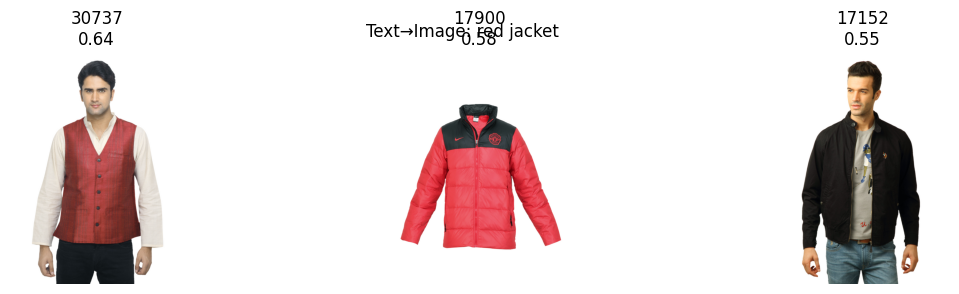

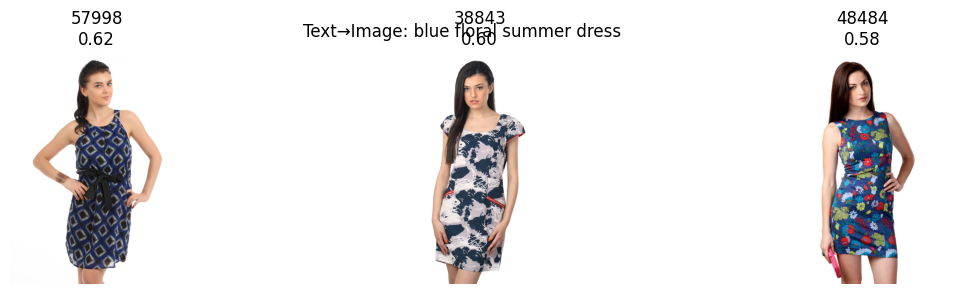

Query image: /kaggle/input/fashion-product-images-dataset/fashion-dataset/images/14996.jpg


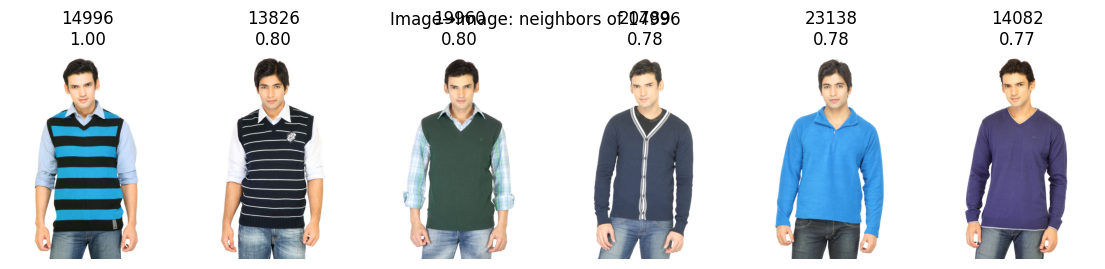

In [ ]:
# TEXT → IMAGE
hits = topk_text_query("red jacket", k=3)
show_results(hits, "Text→Image: red jacket")

hits = topk_text_query("blue floral summer dress", k=3)
show_results(hits, "Text→Image: blue floral summer dress")

# IMAGE → IMAGE (use an existing val image id)
query_iid = str(val_df.iloc[0]['id'])
query_path = os.path.join(IMAGES_PATH, f"{query_iid}.jpg")
print("Query image:", query_path)
neighbors = topk_image_query(query_path, k=6)
show_results(neighbors, f"Image→Image: neighbors of {query_iid}")


In [ ]:
np.savez_compressed("/content/val_image_embeddings.npz",
                    vecs=vecs, ids=np.array(val_item_ids, dtype=object))
faiss.write_index(index, "/content/val_ip.index")
print("Saved: /content/val_image_embeddings.npz, /content/val_ip.index")
